<a href="https://colab.research.google.com/github/AhmetCannnn/deep_learning_projects/blob/main/stock_price_prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COLAB BAĞLANTISININ YAPILMASI

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Long Short-Term Memory (LSTM) ile Hisse Senedi Fiyatı Tahminlenmesi

**1)İş problemi(Business Problem)**

**2)Veriyi Anlamak(Data Understanding)**

**3)Veriyi Hazırlamak(Data Preparation)**

**4)Modelleme(Modeling)**

**5)Değerlendirme(Evaluation)**

# **1) Business Problem**



*   **Date:** İlgili işlem gününün tarihini temsil etmektedir.
*   **Open:** İlgili işlem gününe ait hisse başlangıç fiyatını temsil etmektedir.
*   **High**: İlgili işlem gününe ait en yüksek fiyatı teslim etmektedir.
*  **Low**: İlgili işlem gününe ait en düşük fiyatı temsil etmektedir.
*   **Close**: İlgili işlem gününde hisse senedinin kapanış fiyatını temsil etmektedir.
*   **Adj Close**: İlgili işlem gününe ait hisse senedinin düzeltilmiş kapanış fiyatını temsil etmektedir.
*   **Volume:** İlgili işlem günüe ait işlem hacmini temsil etmektedir.


https://www.kaggle.com/datasets/timoboz/tesla-stock-data-from-2010-to-2020




# **2)Data Understanding**

In [2]:
# Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan küütphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmakiçin kullanılacak kütüphaneler
import warnings
warnings.filterwarnings('ignore')

# Tensorflow warning engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/TSLA.csv') # csv dosyasını direvedan okuma

In [4]:
df.head() # veri setinin ilk 5 satırını gösteren kod satırı

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
def check_df(data_frame,head=5):
  print('##################### Shape #####################')
  print(data_frame.shape)
  print('##################### Types #####################')
  print(data_frame.dtypes)
  print('##################### Head #####################')
  print(data_frame.head(head))
  print('##################### Tail #####################')
  print(data_frame.tail(head))
  print('##################### NA #####################')
  print(data_frame.isnull().sum())
  print('##################### Quantiles #####################')
  # Sadece sayısal sütunları seç
  numeric_df = data_frame.select_dtypes(include=np.number)
  print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

##################### Shape #####################
(2416, 7)
##################### Types #####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
##################### Head #####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
##################### Tail #####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575

# **3)Data Preparation**

In [7]:
df["Date"] = pd.to_datetime(df["Date"]) # Tarih sütununu datetime formatına dönüştürüyoruz.

In [8]:
df.head() # İlk 5 satırı gösteriyoruz.

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [9]:
tesla_df = df[["Date","Close"]] # Tarih ve kapanış fiyatlarını içeren yeni bir DataFrame oluşturuyoruz.

In [10]:
print("Minimum Tarih", tesla_df["Date"].min()) # DataFrame içindeki en küçük tarih
print("Maksimum Tarih", tesla_df["Date"].max()) # DataFrame içindeki en büyük tarih

Minimum Tarih 2010-06-29 00:00:00
Maksimum Tarih 2020-02-03 00:00:00


In [11]:
tesla_df.index = tesla_df["Date"] # DataFrame'in indexini "Date" sütununa göre ayarlıyoruz.

In [12]:
tesla_df # kontrol

,Date,Close
Date,,
2010-06-29,2010-06-29,23.889999
2010-06-30,2010-06-30,23.830000
2010-07-01,2010-07-01,21.959999
2010-07-02,2010-07-02,19.200001
2010-07-06,2010-07-06,16.110001
...,...,...
2020-01-28,2020-01-28,566.900024
2020-01-29,2020-01-29,580.989990
2020-01-30,2020-01-30,640.809998


In [13]:
tesla_df.drop("Date",axis=1,inplace=True)

In [14]:
tesla_df # kontrol

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001
...,...
2020-01-28,566.900024
2020-01-29,580.989990
2020-01-30,640.809998


In [15]:
result_df = tesla_df.copy() # dataframein bir kopyasını alma işlemi

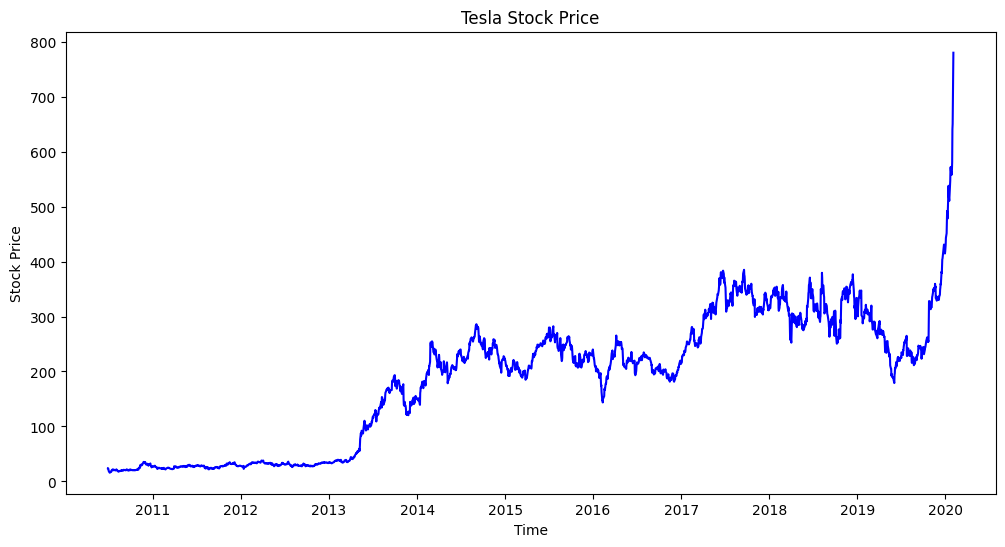

In [16]:
plt.figure(figsize=(12 ,6)) #grafiğin boyutunu ayarlama
plt.plot(tesla_df['Close'], color='blue'); #grafiği çizdirme
plt.ylabel('Stock Price'); #grafiğin başlıklarını ayarlama
plt.xlabel('Time') #grafiğin başlıklarını ayarlama
plt.title("Tesla Stock Price") #grafiğin başlıklarını ayarlama
plt.show() #grafiği gösterme


In [17]:
tesla_df = tesla_df.values # DataFrame'i NumPy dizisine dönüştürme


In [19]:
tesla_df[0:5] # artık dataframe değil numpy arrayı olduğundan dolayı head fonskiyonu kullanılamaz

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [20]:
tesla_df = tesla_df.astype('float32') # veri tipini float32 olarak ayarlama

In [21]:
# train-test ayarının yapılması
# veri seti zaman etkisinde geliştiği için veriyi ayırma işlemini kendimiz basit bir fonksiyon ile ayırıyoruz
def split_data(dataframe, test_size):
  pos = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]
  return train, test, pos

In [82]:
train, test, pos = split_data(tesla_df, 0.20) # fonskiyonu kullanarak veriyi train ve test olarak ayırma işlemi

In [24]:
print(train.shape, test.shape) # ayrılmış veriyi ekrana bastırıyoruz

(1933, 1) (483, 1)


In [25]:
scaler_train = MinMaxScaler(feature_range=(0,1)) # train verisini ölçeklendirme işlemi

In [26]:
train = scaler_train.fit_transform(train) # train verisini ölçeklendirme işlemi

In [27]:
scaler_test = MinMaxScaler(feature_range=(0,1)) # test verisini ölçeklendirme işlemi

In [28]:
test = scaler_test.fit_transform(test) # test verisini ölçeklendirme işlemi

In [29]:
train[0:5] # ölçeklendirilmiş train setinden ilk 5 örneğin gösterilmesi

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [30]:
test[0:5] # ölçeklendirilmiş test setinden ilk 5 örneğin gösterilmesi

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [31]:
# veriyi yorumlarken kaç adım önceki veriye bakarak yorumlama işlemi yapacağımızı belirleyen fonksiyon
def create_features(data, lookback): # data ve lookback argümanlarını alıyor
  X, Y = [], [] # X ve Y listesini oluşturuyor
  for i in range(lookback, len(data)): # verdiğimiz lookbackten verinin uzunluğuna kadar olan kısım kadar döngü çalışacak
    X.append(data[i-lookback:i,0]) # X listesine i-lookback'ten i'ye kadar olan verileri ekliyoruz
    Y.append(data[i, 0]) # Y listesine i'ninci indeksteki değeri ekliyoruz

  return np.array(X), np.array(Y) # X ve Y listesini numpy dizisine dönüştürüp döndürüyoruz

In [32]:
lookback = 20 # lookback değerini 20 olarak belirliyoruz

**Veriyi yorumlarken yourmladığımız veriden önceki 20 veriye bakacağız.**

In [48]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback) # train verisini kullanarak X_train ve y_train oluşturuyoruz

# Test Veri Seti
X_test, y_test = create_features(test, lookback) # test verisini kullanarak X_test ve y_test oluştur

In [49]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # veri setinin boyutlarını ekrana bastırıyoruz

(1913, 20) (1913,) (463, 20) (463,)


In [50]:
X_train[0:5] # ilgili tarihten 20adım öncesine ilişkin featurelar üretmiş olduk

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [51]:
y_train[0:5] # ilgili tarihten 20adım öncesine ilişkin hisse senedi fiyatlarının kendileri

array([0.01332611, 0.01232395, 0.01121344, 0.01386782, 0.01665764],
      dtype=float32)

**LSTM'e veriyi vermek için 3 boyutlu hale getirmemiz gerekir**

In [52]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) # veriyi 3 boyutlu hale getirme
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])) # veriyi 3 boyutlu hale getirme

In [57]:
# Reshape y__train and y_test to have a shape of (number_of_samples, 1)
y_train = np.reshape(y_train, (-1, 1)) # veriyi 2 boyutlu hale getirme
y_test = np.reshape(y_test, (-1, 1))  # veriyi 2 boyutlu hale getirme, typo corrected

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # veri setinin boyutlarını ekrana bastırıyoruz

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


# **Modeling**

In [58]:
model = Sequential() # sıralı model oluşturma
model.add(LSTM(units=50, # modele 50 nöron ekleme
               activation='relu',
               input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2)) # dropout katmanı ekleyerek rastgele şekilde nöron sönğmleme işlemi

model.add(Dense(1)) # tek bir çıktı nöronu

In [59]:
model.summary() # model özeti

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması
model.compile(loss='mean_squared_error', optimizer='adam') # modelin derlenmesi

In [64]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'), # eğitim sırasında durdurma işlemi
                           ModelCheckpoint(filepath='mymodel.h5.keras', monitor='val_loss', mode='min', # en düşük kayıp değerine sahip modeli kaydetme
                           save_best_only=True, save_weights_only=False, verbose=1)] # modelin ve ağırlıkalrın ne şekilde kaydedileceği

In [65]:
history = model.fit(x=X_train, # bağımsız değişken
                    y=y_train, # bağımlı değişken
                    epochs=100, # eğitim iterasyon sayısı
                    batch_size=20, # eğitim için küçük bir lot boyutu
                    validation_data=(X_test, y_test), # doğrulama veri seti
                    callbacks= callbacks, # eğitim sırasında durdurma ve kaydetme işlemi
                    shuffle=False)  # eğitim sırasında veri setinin karıştırılması(False)

Epoch 1/100
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 1: val_loss improved from inf to 0.00367, saving model to mymodel.h5.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 2/100
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 2: val_loss improved from 0.00367 to 0.00305, saving model to mymodel.h5.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 3/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 3: val_loss improved from 0.00305 to 0.00291, saving model to mymodel.h5.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 4/100
80/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 4: val_loss improved from 0.00291 to 0.00260, saving model to mymodel.h5.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 5/100
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015    
Epoch 5: val_loss improved from 0.0026

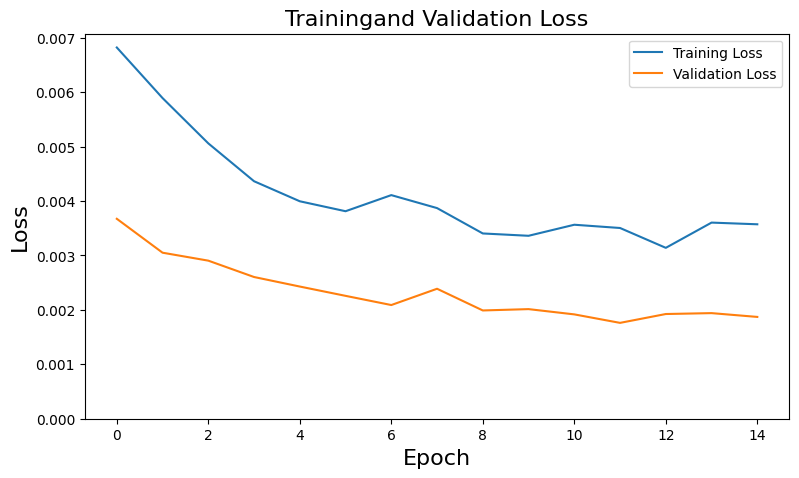

In [66]:
plt.figure(figsize=(20, 5)) #grafiğin boyutunu ayarlama
plt.subplot(1, 2, 2) #grafiğin alt grafiklerini ayarlamak için kullanılır
plt.plot(history.history['loss'], label='Training Loss') #grafiği çizdirme
plt.plot(history.history['val_loss'], label='Validation Loss') #grafiği çizdirme
plt.xlabel('Epoch', fontsize=16) #grafiğin başlıklarını ayarlama
plt.ylabel('Loss', fontsize=16) #grafiğin başlıklarını ayarlama
plt.legend(loc='upper right') #grafiğin başlıklarını ayarlama
plt.ylim([0,max(plt.ylim())]) #grafiğin başlıklarını ayarlama
plt.title('Trainingand Validation Loss', fontsize=16) #grafiğin başlıklarını ayarlama
plt.show() #grafiği göster

# **5)Evaluation**

In [67]:
loss =model.evaluate(X_test, y_test, batch_size=20) # modelin değerlendirilmesi
print("\nTest loss: %.1f%%" % (100.0 * loss)) # modelin kaybı

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014     

Test loss: 0.2%


In [74]:
# standartlaştırılmış olan train ve test setlerini gerçek değerlerine geri döndürüyoruz
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [75]:
train_predict = scaler_train.inverse_transform(train_predict) # train setini geri dönüştürme
test_predict = scaler_test.inverse_transform(test_predict) # test setini geri dönüştürme

In [76]:
y_train = scaler_train.inverse_transform(y_train) # train setini geri dönüştürme
y_test = scaler_test.inverse_transform(y_test) # test setini geri dönüştürme

In [77]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))


In [72]:
# Test verş setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [80]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 71154.40625
Test RMSE: 25.99739646911621


In [84]:
train_prediction_df = result_df[lookback:pos] # train setini oluşturma
train_prediction_df['Predicted'] = train_predict # train setine tahmin edilen değerleri ekleme
train_prediction_df.head() # train setinin ilk 5 satırını gösterme

,Close,Predicted
Date,,
2010-07-28,20.719999,33.902466
2010-07-29,20.350000,33.764660
2010-07-30,19.940001,33.628105
2010-08-02,20.920000,33.584846
2010-08-03,21.950001,33.594311


In [85]:
test_prediction_df = result_df[pos+lookback:] # train setini oluşturma
test_prediction_df['Predicted'] = test_predict # train setine tahmin edilen değerleri ekleme
test_prediction_df.head() # train setinin ilk 5 satırını gösterme

,Close,Predicted
Date,,
2018-04-03,267.529999,306.420624
2018-04-04,286.940002,303.939484
2018-04-05,305.720001,303.480896
2018-04-06,299.299988,304.867310
2018-04-09,289.660004,305.563934


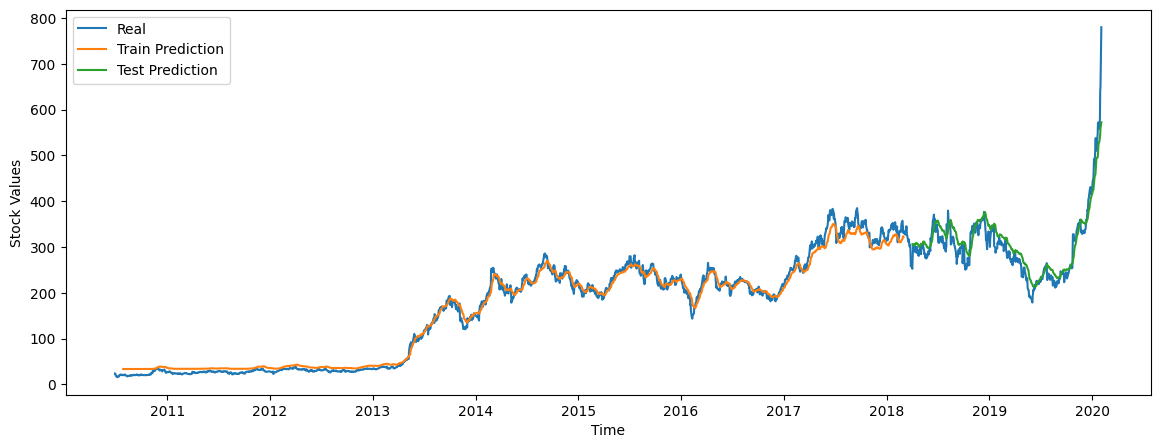

In [86]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14, 5)) #grafiğin boyutunu ayarlama
plt.plot(result_df, label ='Real') #grafiği çizdirme
plt.plot(train_prediction_df['Predicted'], label ='Train Prediction') #grafiği çizdirme
plt.plot(test_prediction_df['Predicted'], label ='Test Prediction') #grafiği çizdirme
plt.xlabel('Time') #grafiğin başlıklarını ayarlama
plt.ylabel('Stock Values') #grafiğin başlıklarını ayarlama
plt.legend() #grafiğin başlıklarını ayarlama
plt.show() #grafiği göster